# Convolutional LSTM Many To One Neural Network

Implementing a Convolutional LSTM with 6 entry channels being them `[T_int, Q_heat, T_env, T_prev, mask_interfaces, mask_heaters]`, all in shape `[T, 13, 13]`

## Previous

In [18]:
import os
import sys
import IPython

# Detectar si estamos en Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Ruta base
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/MyDrive/ia_thermal_colab"
else:
    BASE_PATH = os.path.expanduser("~/ia_thermal_colab")

DATASETS_PATH = os.path.join(BASE_PATH, "datasets")
MODELS_PATH = os.path.join(BASE_PATH, "models")

os.makedirs(DATASETS_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

print("Modo:", "Colab" if IN_COLAB else "Local")
print("Ruta datasets:", DATASETS_PATH)
print("Ruta modelos:", MODELS_PATH)

Modo: Local
Ruta datasets: C:\Users\ismael.gallo/ia_thermal_colab\datasets
Ruta modelos: C:\Users\ismael.gallo/ia_thermal_colab\models


In [19]:
# 🔄 Parámetros del repo
GIT_REPO_URL = "https://github.com/ismaelgallolopez/ia_thermal.git"  # 👈 Cambia esto
REPO_NAME = GIT_REPO_URL.split("/")[-1].replace(".git", "")
CLONE_PATH = os.path.join(BASE_PATH, REPO_NAME)

if IN_COLAB:
    # 🧬 Clonar el repositorio si no existe ya
    if not os.path.exists(CLONE_PATH):
        !git clone {GIT_REPO_URL} {CLONE_PATH}
    else:
        print(f"Repositorio ya clonado en: {CLONE_PATH}")

    # 📦 Instalar requirements.txt
    req_path = os.path.join(CLONE_PATH, "requirements.txt")
    if os.path.exists(req_path):
        !pip install -r {req_path}
    else:
        print("No se encontró requirements.txt en el repositorio.")

    print("🔄 Reinicia el entorno para aplicar los cambios...")
    IPython.display.display(IPython.display.Javascript('''google.colab.restartRuntime()'''))

Importación de librerías necesarias


In [20]:
import numpy as np
import time
from datetime import datetime
from IPython.display import display, Markdown
import platform
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import optuna
from typing import Sequence, Union, Optional
import seaborn as sns


import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim

np.set_printoptions(threshold=sys.maxsize)
torch.set_default_dtype(torch.float32)

# get the directory path of the file
dir_path = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal")

from plot_functions import *
from Physics_Loss import *
from utils import *
from scripts.PCB_solver_tr import *

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal/ismaelgallo")

from architectures.convlstm import *
from Dataset_Class_convlstm import *

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print('Using device:', device)

Using device: cuda


In [22]:
system_specs = {
    "os": platform.system(),  # e.g. "Linux", "Windows", "Darwin"
    "os_version": platform.version(),
    "machine": platform.machine(),  # e.g. "x86_64"
    "processor": platform.processor(),  # e.g. "Intel64 Family 6 Model 158"
    "python_version": platform.python_version(),
    "device": str(device)
}
if torch.cuda.is_available():
    system_specs["gpu_name"] = torch.cuda.get_device_name(0)
    system_specs["gpu_memory_total_GB"] = round(torch.cuda.get_device_properties(0).total_memory / (1024**3), 2)
    system_specs["cuda_version"] = torch.version.cuda

In [23]:
plt.rcParams.update({
    # 'text.usetex': True,  # Usar LaTeX para el texto (Local)
    'text.usetex': False,  # NO Usar LaTeX para el texto (Colab)
    'font.family': 'serif',  # Fuente serif
    # 'figure.figsize': (10, 6),  # Tamaño de la figura
    'axes.labelsize': 12,  # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Tamaño del título
    'legend.fontsize': 12,  # Tamaño de la leyenda
    'xtick.labelsize': 10,  # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Tamaño de las etiquetas del eje y
    'axes.grid': True,  # Habilitar la cuadrícula
    'grid.alpha': 0.75,  # Transparencia de la cuadrícula
    'grid.linestyle': '--'  # Estilo de la línea de la cuadrícula
})

# Configuración de Seaborn
sns.set_context('paper')
sns.set_style('whitegrid')

## Dataset import

In [24]:
n_train = 1500
n_val = 200 
n_test = 20
time_sim = 100 # seconds

batch_size = 128

sequence_length = time_sim+1 # seconds
dt = 1 # seconds
T_init = 298.0 # Kelvin
nodes_side = 13 # number of nodes in one side of the PCB

In [25]:
if IN_COLAB:
  dir_path = BASE_PATH

dataset = load_dataset_convlstm(base_path=dir_path)  

dataset_train = load_trimmed_dataset_convlstm(base_path=dir_path, dataset_type='train', max_samples=n_train, time_steps_output=sequence_length, to_device=True)
dataset_val = load_trimmed_dataset_convlstm(base_path=dir_path, dataset_type='val', max_samples=n_val, time_steps_output=sequence_length, to_device=True)
dataset_test = load_trimmed_dataset_convlstm(base_path=dir_path, dataset_type='test', max_samples=n_test, time_steps_output=sequence_length, to_device=True)

# ⇩ ENVOLVEMOS EN VENTANAS Many→One
K_window   = 5          # el tamaño que hayas elegido
stride     = 1

train_ds = PCBDatasetSliding(dataset_train, window_size=K_window, stride=stride)
val_ds   = PCBDatasetSliding(dataset_val  , window_size=K_window, stride=stride)
test_ds  = PCBDatasetSliding(dataset_test , window_size=K_window, stride=stride)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds  , batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds , batch_size=batch_size, shuffle=False)

✅ Cargando ConvLSTM transient dataset base desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset.pth
✅ Cargando dataset train desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_train.pth


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(full_path)
c:\Users\ismael

📦 Dataset movido a: CUDA
✅ Cargando dataset val desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_val.pth
📦 Dataset movido a: CUDA
✅ Cargando dataset test desde: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\datasets\PCB_convlstm_6ch_transient_dataset_test.pth
📦 Dataset movido a: CUDA


In [26]:
# flat_dataset = FlattenedTemporalDataset(dataset_train)
# flat_loader = DataLoader(flat_dataset, batch_size=128, shuffle=True)

# for x, y in flat_loader:
#     print(x.shape)  # (batch, C, H, W)
#     print(y.shape)  # (batch, H, W)
#     break

##### Comprobaciones de que no nos estamos cargando nada por el camino

In [27]:
for x_batch, y_batch in train_loader:
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break  # Solo muestra el primer batch

x_batch shape: torch.Size([128, 5, 6, 13, 13])
y_batch shape: torch.Size([128, 1, 13, 13])


In [28]:
# for i in range(6):
#     print(x_batch[0, 0, i, :, :])

torch.Size([13, 13])


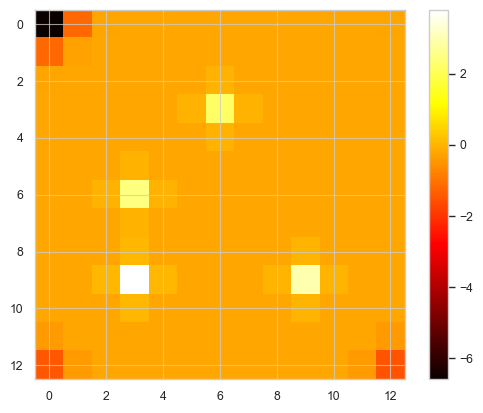

In [29]:
x, _ = next(iter(train_loader))
img = x[0, 0, 3, :, :]  # img should be shape (13, 13)
print(img.shape)     # Should print torch.Size([13, 13])

plt.imshow(img.cpu().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## Non-phyisics ConvLSTM

### Hyperparameters

In [30]:
epochs = 1000
lr = 1e-2
lrdecay = 0.1
lrdecay_patience = 10
early_stop_patience = 100

hidden_dims = [128, 128]  # Número de filtros en cada capa LSTM
num_layers = len(hidden_dims)
kernel_size = [(3,3)] * num_layers

### Model definition

ConvLSTM arquitecture

In [35]:
class PCB_ConvLSTM(nn.Module):
    def __init__(self, input_channels=6, hidden_dims=[64, 64, 64], kernel_size=[(3,3), (3,3), (3,3)], height=13, width=13):
        super().__init__()
        self.convlstm = ConvLSTM(input_dim=input_channels,
                                 hidden_dim=hidden_dims,
                                 kernel_size=kernel_size,
                                 num_layers=len(hidden_dims),
                                 batch_first=True,
                                 bias=True,
                                 return_all_layers=False)
        self.decoder = nn.Conv2d(hidden_dims[-1], 1, kernel_size=1)

    def forward(self, x):
        # x: (batch*time, C, H, W)
        # Añadimos una dimensión temporal ficticia para usar ConvLSTM
        # x = x.unsqueeze(1)  # (batch*time, 1, C, H, W)
        lstm_out, _ = self.convlstm(x)  # lstm_out[0]: (batch*time, 1, hidden_dim, H, W)
        out = self.decoder(lstm_out[0][:, 0])  # (batch*time, 1, H, W)
        return out

Model itself

In [36]:
model = PCB_ConvLSTM(input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lrdecay, patience=lrdecay_patience)

# # DEBUGGING
# # Ensure data is moved to the appropriate device
# batch = next(iter(train_loader))
# x, y = batch

# print(f"x está en: {x.device}")
# print(f"y está en: {y.device}")
# print(f"model está en: {next(model.parameters()).device}")

### Training

Training and saving best model with best parameters.

In [37]:
train_loss = []
val_loss = []
best_val_loss = np.inf
epochs_without_improvement = 0
elapsed_previous = 0.0  # minutos ya entrenados en sesiones anteriores

kernel_string = f"{kernel_size[0][0]}x{kernel_size[0][1]}"
layer_string = f"{hidden_dims[0]}"
for d in hidden_dims[1:]:
    layer_string += f"-{d}"

model_dir = os.path.join(dir_path, 'models', 'ConvLSTM_6ch', 'manytone')
if IN_COLAB:
    model_dir = os.path.join(MODELS_PATH, 'ConvLSTM_6ch', 'manytone')
os.makedirs(model_dir, exist_ok=True)

filename = f"PCB_ConvLSTM_6ch_nt{n_train}_e{epochs}_{time_sim}s_lr{lr}_bs{batch_size}_h{layer_string}_k{kernel_string}.pth"
model_path = os.path.join(model_dir, filename)
json_path  = model_path.replace('.pth', '.json')

start_epoch = 0
start_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# --- Lógica de reanudación ---
if os.path.exists(model_path):
    display(Markdown(f"🔁 Cargando modelo existente `{filename}` y reanudando entrenamiento."))
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            prev = json.load(f)
        best_val_loss         = prev.get('best_val_loss', best_val_loss)
        train_loss            = prev.get('train_loss', [])
        val_loss              = prev.get('val_loss', [])
        elapsed_previous      = prev.get('training_duration_minutes', 0.0)
        start_datetime        = prev.get('start_datetime', start_datetime)
        start_epoch           = prev.get('epochs_trained', 0)
        # Reiniciamos el contador de paciencia tras mejora
        epochs_without_improvement = 0
    else:
        display(Markdown("⚠️ No se encontró JSON de hiperparámetros; se reinicia contadores."))
else:
    display(Markdown(f"✨ Nuevo entrenamiento: `{filename}`"))

print("📁 Los resultados se guardarán en:", json_path)

✨ Nuevo entrenamiento: `PCB_ConvLSTM_6ch_nt1500_e1000_100s_lr0.01_bs128_h128-128_k3x3.pth`

📁 Los resultados se guardarán en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\ConvLSTM_6ch\manytone\PCB_ConvLSTM_6ch_nt1500_e1000_100s_lr0.01_bs128_h128-128_k3x3.json


In [ ]:
# --- Bucle de entrenamiento desde start_epoch ---
elapsed_minutes = elapsed_previous 
start_time_training = time.time() - (elapsed_previous * 60)

for epoch in range(start_epoch, epochs):
    model.train()
    total_loss = 0.0
    start_time_epoch = time.time()

    # Entrenamiento
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):

        optimizer.zero_grad()
        y_hat = model(x)

        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()

    epoch_train_loss = total_loss / len(train_loader)
    train_loss.append(epoch_train_loss)

    # Validación
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            y_pred = model(x_val)
            val = criterion(y_pred, y_val)
            total_val_loss += val.item()

    epoch_val_loss = total_val_loss / len(val_loader)
    val_loss.append(epoch_val_loss)

    # Scheduler update
    scheduler.step(epoch_val_loss)

    # Early stopping check
    elapsed_training = time.time() - start_time_training
    elapsed_minutes = elapsed_training / 60
    current_lr = optimizer.param_groups[0]['lr']
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss

        # Guardar el modelo
        torch.save(model.state_dict(), model_path)



        # Guardar hiperparámetros en JSON
        params = {
            'start_datetime': start_datetime,
            'training_duration_minutes': elapsed_minutes,
            "system_specs": system_specs,
            'hidden_dims': hidden_dims,
            'kernel_size': kernel_string,
            'batch_size': batch_size,
            'lr': lr,
            "scheduler":{
                "type": "ReduceLROnPlateau",
                "factor": lrdecay,
                "patience": lrdecay_patience,
                "final_lr": current_lr
            },
            'early_stop_patience': early_stop_patience,
            'epochs_trained': epoch + 1,
            'best_val_loss': best_val_loss,
            "train_loss": list(map(float, train_loss)),
            "val_loss": list(map(float, val_loss)),
        }

        with open(json_path, 'w') as f:
            json.dump(params, f, indent=4)

        # print(f"✓ Saving model (epoch {epoch+1}) | val_loss improved to {best_val_loss:.6f}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        # print(f"No improvement for {epochs_without_improvement} epoch(s)")

    if epochs_without_improvement >= early_stop_patience:
        print(f"⚠️ Early stopping at epoch {epoch+1} — no improvement for {early_stop_patience} epochs.")
        break

    # Estadísticas finales de la época
    elapsed_epoch = time.time() - start_time_epoch
    # print(f"Epoch {epoch+1:3d} | Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f} | Time: {elapsed_epoch:.2f}s")

print(f"Entrenamiento finalizado en {elapsed_minutes:.2f} minutos.")

Epoch 2/1000 - Training:  68%|██████▊   | 48/71 [00:23<00:11,  2.00it/s]

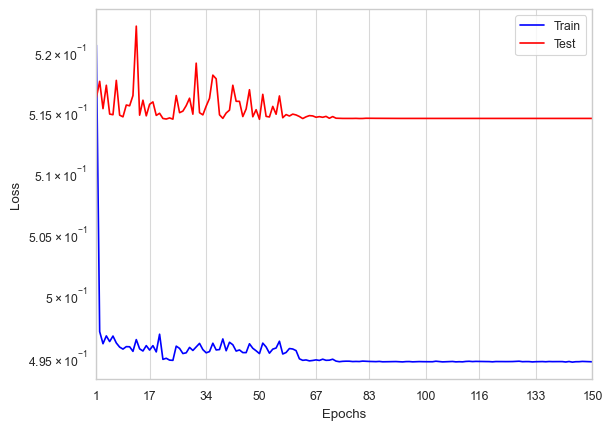

In [ ]:
plot_loss_evolution(train_loss, val_loss)

### Testing

In [ ]:
# load the best model
model = PCB_ConvLSTM(input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Use a batch from val_loader for evaluation
x_val, y_val = next(iter(val_loader))

with torch.no_grad():
    y_pred = model(x_val)  # (B, T, 1, H, W)
    val_loss = criterion(y_pred, y_val)
    print(f"Val Loss: {val_loss.item():.6f}")

Val Loss: 0.480023


C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_17672\1119888986.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


### Analyzing results

In [ ]:
model = PCB_ConvLSTM(input_channels=6, hidden_dims=hidden_dims, kernel_size=kernel_size, height=13, width=13).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

C:\Users\ismael.gallo\AppData\Local\Temp\ipykernel_17672\2614459443.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


PCB_ConvLSTM(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(134, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
)

We are going to plot the temperature evolution in the four nodes corresponding with the heaters

In [ ]:
id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Boundary conditions

In [ ]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([290, 290, 290, 290])
T_env = 250

Actual values

In [ ]:
T, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = dt, T_init = T_init, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T_true = T.reshape(T.shape[0], nodes_side, nodes_side) # reshaping the data grid-shape

Predicted values

In [ ]:
T_true_tensor = torch.tensor(T_true, dtype=torch.float32).to(device)  # (T, H, W)
# input_tensor0 = dataset.create_input_from_values(Q_heaters, T_interfaces, T_env, T_true_tensor, sequence_length=sequence_length, autorregress=True)
T_true_tensor = T_true_tensor.to('cpu')

T_pred = rollout_convlstm_6ch_onetoone(model, dataset, Q_heaters, T_interfaces, T_env, n_steps=sequence_length)
T_pred_tensor = torch.tensor(T_pred, dtype=torch.float32).to('cpu')  # (T, H, W)

# output = model(input_tensor)
# output_denorm = dataset.denormalize_output(output)
# T_pred_tensor = output_denorm[0,:,0,:,:].cpu()
# T_pred = T_pred_tensor.detach().numpy()

Calculando input tensor para predicción, solo el primer paso de la secuencia
Input tensor shape: torch.Size([1, 1, 6, 13, 13])


c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\Dataset_Class_convlstm.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_seq = torch.tensor(T_seq, dtype=torch.float32)


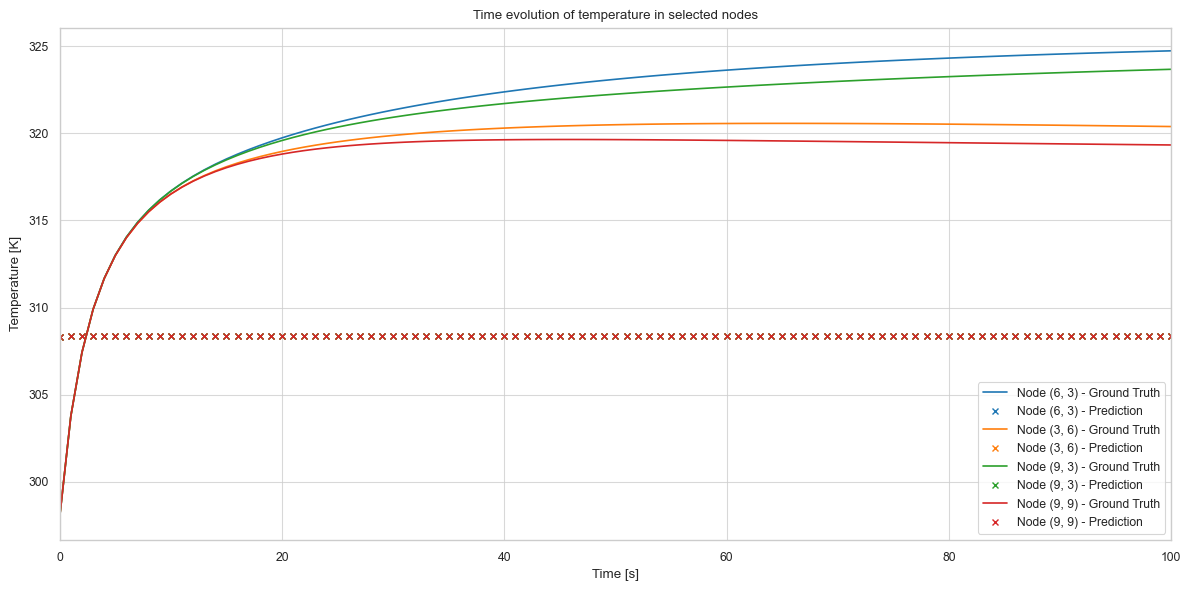

In [ ]:
plot_nodes_evolution(T_pred, T_true, id_heaters, together=True)

Erorr bands

In [ ]:
umbral = 5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 5.0 K: 76.58%
Porcentaje de nodos buenos: 59.17%


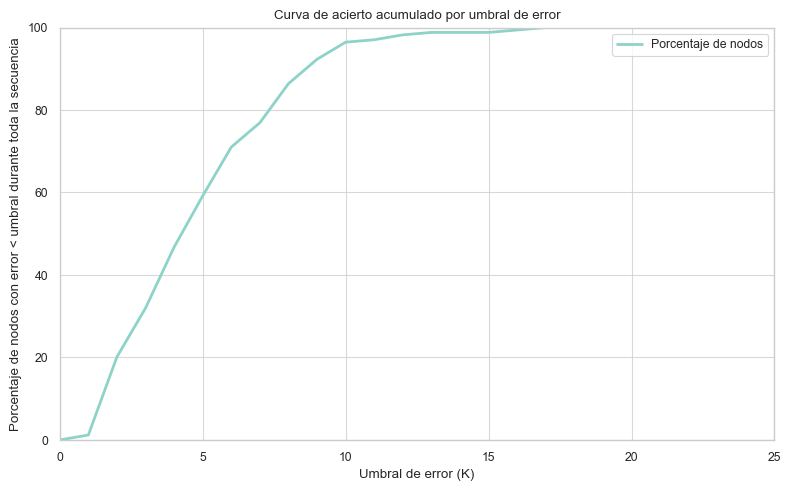

In [ ]:
umbrales = np.linspace(0, 25, 26)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

Animation of both results

In [ ]:
ani = generar_gif_pcb_comparacion(T_pred, T_true, guardar_en_figures=True, nombre_archivo='prueba_6ch')

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Guardando gif en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\prueba_6ch.gif
Gif guardado.


Animation of the error

In [ ]:
ani = generar_gif_error_evolucion(T_pred, T_true, guardar_en_figures=True)

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Evolución del error con el tiempo

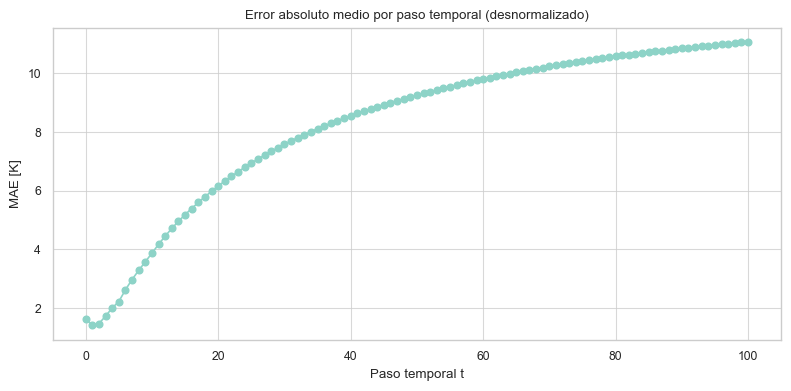

In [ ]:
plot_mae_per_frame(T_pred_tensor.detach(), T_true_tensor.detach(), dataset)

Error en cada nodo

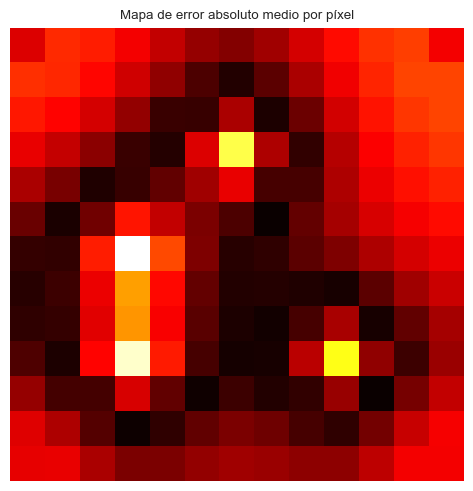

In [ ]:
plot_mae_per_pixel(T_pred_tensor.detach(), T_true_tensor.detach(), dataset)